# ALS Improved Implementation

We provide a more succinct numpy implementation and use numba on top for further acceleration

Reference: https://github.com/benlindsay/als-wr-tutorial/blob/master/modified_notebook.ipynb

## Imports

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from numba import jit, njit

# Data Preprocessing

In [105]:
data = pd.read_csv('../data/data_train.csv', index_col=0)

# rename column and turn ot uint8
data.rename(columns={'Prediction': 'Rating'}, inplace=True)
data['Rating'] = data['Rating'].astype('uint8')

# get user and movie id by splitting index given in format rX_cY
data['UserId'] = data.index.str.split('_').str[0].str[1:].astype('int32')
data['MovieId'] = data.index.str.split('_').str[1].str[1:].astype('int32')

# subtract min UserId and MovieID to get indices starting at 0
data['UserId'] = data['UserId'] - data['UserId'].min()
data['MovieId'] = data['MovieId'] - data['MovieId'].min()

# reorder columns to UserId, MovieId, Rating
data = data[['UserId', 'MovieId', 'Rating']]

# split into train and val data
# train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
train_data = data
val_data = data

In [106]:
# function to get sparse matrix from data given as a dataframe with row and column indices
def get_sparse_matrix(data, n_rows, n_cols):
    return csr_matrix((data['Rating'].values, (data['UserId'].values, data['MovieId'].values)), shape=(n_rows, n_cols))

n_rows = train_data['UserId'].max() + 1 # might raise errors if in val set user with larger id
n_cols = train_data['MovieId'].max() + 1 # might raise errors if in val set movie with larger id
train_matrix = get_sparse_matrix(train_data, n_rows, n_cols)
val_matrix = get_sparse_matrix(val_data, n_rows, n_cols)

### ALS algorithm

In [107]:
R = train_matrix.toarray()
T = val_matrix.toarray()

# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

### Loss function

In [108]:
# Calculate the RMSE
def rmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

In [109]:
lmbda = 0.08 # Regularisation weight
k = 10 # Dimensionality of latent feature space
m, n = R.shape # Number of users and items
n_epochs = 150 # Number of epochs

P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

In [110]:
# First, re-initialize P and Q
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie

In [111]:
# Uset different train and test errors arrays so I can plot both versions later
train_errors_fast = []
test_errors_fast = []

# Repeat until convergence
# @njit
def fast_step(P, Q, E, R, I, n_epochs, k, lmbda, verbose=False):
        # Fix Q and estimate P
        for i, Ii in enumerate(I):
            nui = np.count_nonzero(Ii) # Number of items user i has rated
            if (nui == 0): nui = 1 # Be aware of zero counts!
        
            # Least squares solution
            
            # Replaced lines
            #-----------------------------------------------------------
            # Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
            # Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
            #-----------------------------------------------------------
            
            # Added Lines
            #-------------------------------------------------------------------
            # Get array of nonzero indices in row Ii
            Ii_nonzero = np.nonzero(Ii)[0]
            # Select subset of Q associated with movies reviewed by user i
            Q_Ii = Q[:, Ii_nonzero]
            # Select subset of row R_i associated with movies reviewed by user i
            R_Ii = R[i, Ii_nonzero]
            Ai = np.dot(Q_Ii, Q_Ii.T) + lmbda * nui * E
            Vi = np.dot(Q_Ii, R_Ii.T)
            #-------------------------------------------------------------------
            
            P[:, i] = np.linalg.solve(Ai, Vi)
            
        # Fix P and estimate Q
        for j, Ij in enumerate(I.T):
            nmj = np.count_nonzero(Ij) # Number of users that rated item j
            if (nmj == 0): nmj = 1 # Be aware of zero counts!
            
            # Least squares solution
            
            # Removed Lines
            #-----------------------------------------------------------
            # Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
            # Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
            #-----------------------------------------------------------
            
            # Added Lines
            #-----------------------------------------------------------------------
            # Get array of nonzero indices in row Ij
            Ij_nonzero = np.nonzero(Ij)[0]
            # Select subset of P associated with users who reviewed movie j
            P_Ij = P[:, Ij_nonzero]
            # Select subset of column R_j associated with users who reviewed movie j
            R_Ij = R[Ij_nonzero, j]
            Aj = np.dot(P_Ij, P_Ij.T) + lmbda * nmj * E
            Vj = np.dot(P_Ij, R_Ij)
            #-----------------------------------------------------------------------
            
            Q[:,j] = np.linalg.solve(Aj,Vj)

        return P, Q
    
    
def als_fast(P, Q, E, R, I, n_epochs, k, lmbda, verbose=False, early_stopping=False, patience=2):
    train_errors_fast = []
    test_errors_fast = []
    if early_stopping:
        new_patience = patience
    # Repeat until convergence
    for epoch in range(n_epochs):
        P, Q = fast_step(P, Q, E, R, I, n_epochs, k, lmbda, verbose=False)
        train_rmse = rmse(I,R,Q,P)
        test_rmse = rmse(I2,T,Q,P)
        train_errors_fast.append(train_rmse)
        test_errors_fast.append(test_rmse)
        if verbose:
            print("[Epoch %d/%d] train error: %f, test error: %f" \
        %(epoch+1, n_epochs, train_rmse, test_rmse))
        if early_stopping:
            if epoch > 1:
                if test_errors_fast[-1] >= test_errors_fast[-2]:
                    new_patience -= 1
                    if new_patience == 0:
                        print("Early stopping at epoch %d" % epoch)
                        break
                else:
                    new_patience = patience
    return P, Q, train_errors_fast, test_errors_fast
    

In [112]:
%%time

P, Q, train_errors_fast, test_errors_fast = als_fast(P, Q, E, R, I, n_epochs, k, lmbda, verbose=True)
print("Algorithm converged")

[Epoch 1/150] train error: 1.119691, test error: 1.119691
[Epoch 2/150] train error: 1.020440, test error: 1.020440
[Epoch 3/150] train error: 0.989822, test error: 0.989822
[Epoch 4/150] train error: 0.971923, test error: 0.971923
[Epoch 5/150] train error: 0.961215, test error: 0.961215
[Epoch 6/150] train error: 0.954239, test error: 0.954239
[Epoch 7/150] train error: 0.949441, test error: 0.949441
[Epoch 8/150] train error: 0.945997, test error: 0.945997
[Epoch 9/150] train error: 0.943437, test error: 0.943437
[Epoch 10/150] train error: 0.941475, test error: 0.941475
[Epoch 11/150] train error: 0.939931, test error: 0.939931
[Epoch 12/150] train error: 0.938692, test error: 0.938692
[Epoch 13/150] train error: 0.937680, test error: 0.937680
[Epoch 14/150] train error: 0.936842, test error: 0.936842
[Epoch 15/150] train error: 0.936139, test error: 0.936139
[Epoch 16/150] train error: 0.935543, test error: 0.935543
[Epoch 17/150] train error: 0.935035, test error: 0.935035
[Epoch

## Training visualisation

We plot the loss of train/test over epochs

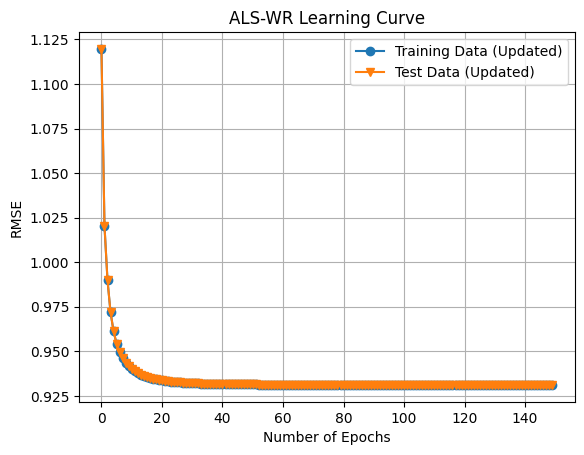

In [113]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt

# Added curves for errors from updated algorithm to make sure the accuracy is unchanged (aside from random deviations)
plt.plot(range(n_epochs), train_errors_fast, marker='o', label='Training Data (Updated)')
plt.plot(range(n_epochs), test_errors_fast, marker='v', label='Test Data (Updated)')
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

## Hyperparameter tuning

In [103]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the hyperparameters to search over
lmbda_values = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
k_values = [4, 5, 6, 7, 8, 9, 10]

# Define the number of epochs to use
n_epochs = 30

# Define a function to compute the RMSE for a given set of hyperparameters
def compute_rmse(lmbda, k):
    # First, re-initialize P and Q
    P = 3 * np.random.rand(k,m) # Latent user feature matrix
    Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
    Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
    E = np.eye(k) # (k x k)-dimensional idendity matrix
    P, Q, train_errors, test_errors = als_fast(P, Q, E, R, I, n_epochs, k, lmbda, verbose=False, early_stopping=True)
    error = test_errors[-1]
    return error

# Perform grid search over the hyperparameters
best_rmse = float('inf')
best_lmbda = None
best_k = None

for lmbda in lmbda_values:
    for k in k_values:
        error = compute_rmse(lmbda, k)
        print(f'lmbda={lmbda}, k={k}, RMSE={error}')
        if error < best_rmse:
            best_rmse = error
            best_lmbda = lmbda
            best_k = k

# Print the best hyperparameters
print(f'Best hyperparameters: lmbda={best_lmbda}, k={best_k}, RMSE={best_rmse}')

lmbda=0.05, k=4, RMSE=0.990304188872084
lmbda=0.05, k=5, RMSE=0.9899116234736589
lmbda=0.05, k=6, RMSE=0.989837790716872
lmbda=0.05, k=7, RMSE=0.9909624011466325
lmbda=0.05, k=8, RMSE=0.9928511244228372
lmbda=0.05, k=9, RMSE=0.9940387117420055
lmbda=0.05, k=10, RMSE=0.9958845685586923
lmbda=0.06, k=4, RMSE=0.9902997582933882
lmbda=0.06, k=5, RMSE=0.9888473791844126
lmbda=0.06, k=6, RMSE=0.9887884746074029
lmbda=0.06, k=7, RMSE=0.9888975617758126
lmbda=0.06, k=8, RMSE=0.9899238561244484
lmbda=0.06, k=9, RMSE=0.9903268776425594
lmbda=0.06, k=10, RMSE=0.991001909878466
lmbda=0.07, k=4, RMSE=0.9900320655733513
lmbda=0.07, k=5, RMSE=0.9887541826789265
lmbda=0.07, k=6, RMSE=0.9879515993833
lmbda=0.07, k=7, RMSE=0.9880714538505825
lmbda=0.07, k=8, RMSE=0.9879350096992991
lmbda=0.07, k=9, RMSE=0.9880214943397736
lmbda=0.07, k=10, RMSE=0.9889977394727131
lmbda=0.08, k=4, RMSE=0.9905403933267762
lmbda=0.08, k=5, RMSE=0.9890949544186208
lmbda=0.08, k=6, RMSE=0.9881039043817745
lmbda=0.08, k=7, RM

## Saving submission

Make predictions on validation data and save the csv

In [102]:
# Make predictions for all entries in the matrix
preds = np.dot(P.T, Q)

# Load the sample submission file
submission = pd.read_csv('../data/sampleSubmission.csv')

# Extract the row and column indices from the 'Id' column
submission['row_idx'] = submission['Id'].str.extract(r'r(\d+)_c\d+').astype(int) - 1
submission['col_idx'] = submission['Id'].str.extract(r'r\d+_c(\d+)').astype(int) - 1

# Update the predictions in the submission file
submission['Prediction'] = preds[submission['row_idx'], submission['col_idx']]

# Drop the row and column indices
submission.drop(['row_idx', 'col_idx'], axis=1, inplace=True)

# Save the updated submission file
submission.to_csv('../data/mySubmission.csv', index=False)